In [1]:
from datetime import datetime
from random import randint
import sys

import torch
from torch import tensor, nn
from torch.utils.tensorboard import SummaryWriter

from lib.metrics.accuracy import get_accuracy
from lib.models.hlim import HardLimit
from lib.models.perceptron import create_perceptron
from lib.widgets.mlp_response_view import MLPResponseView
from lib.widgets.mlp_arch_view import MLPArchView
from IPython.display import display

/home/robbe/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. The perceptron

The perceptron is the simplest one-layer network. It consists of $R$ inputs and 1 output. Each of the $R$ inputs is multiplied by a *weight*. The outputs of these multiplications are summed and a *bias* is added to the result. Finally, the resulting number will be passed through the *hard-limit* activation function. This function returns $1$ whenever its input is positive and $0$ when the input is negative. The perceptron is used as a simple classification tool.

You can use the function `get_perceptron()` to create a perceptron with a certain number of input neurons and a single output neuron. With the `MLPArchView` and `MLPResponseView` classes, you can visualize the architecture and the response of the perceptron.

The response plot shows a heatmap with the output value $y$ of the perceptron to different input values $(x_0, x_1)$. As indicated on the color bar next to the graph, values for $(x_0, x_1)$ that fall in the purple region map to an output value of $y=0$. Those falling in the yellow region map to an output $y=1$.

We add some annotated samples to the plot to see in which region they fall. Their fill color shows their true class and their edge color indicates whether or not the perceptron classifies the sample correctly. **Can you change the perceptron weights and bias such that all training samples are classified correctly?**

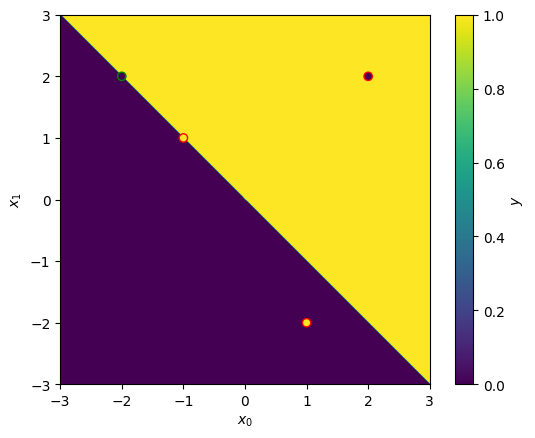

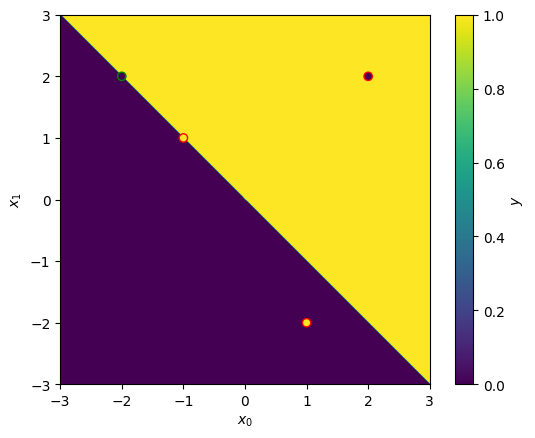

In [2]:
# A batch of (x0, x1) inputs
x = tensor([[2., 2.],
            [1., -2.],
            [-2., 2.],
            [-1., 1.]])

# A batch of desired outputs y
y = tensor([[0.],
            [1.],
            [0.],
            [1.]])

# Create a perceptron
ptron = create_perceptron()

# Modify the weights and bias values
ptron.weights = [torch.tensor([[1., 1.]])]
ptron.biases = [torch.tensor([0.])]

# Visualize the response and the architecture
resp_view = MLPResponseView(ptron, data_x=x, data_y=y)
arch_view = MLPArchView(ptron)
display(arch_view, resp_view.fig)

## 1.1 Implement your own perceptron

We will now implement our own perceptron in PyTorch. To do this, we need to implement a class that **inherits from `torch.nn.Module`**. The class must implement a method called `forward()` that takes in the network input and returns the network output. A perceptron linearly combines its input, adds a bias and passes this through a hard-limit activation.

- For the linear combination (with bias), you can create an instance of [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). With the constructor arguments `in_features` (int), `out_features` (int) and `bias` (bool), you can control the number of input neurons, output neurons and whether or not a bias should be added, respectively.
- We have already implemented the hard-limit "layer" for you.

**Copy the code below and paste it into a code cell and complete it to create your first perceptron**!

```python
class Perceptron(nn.Module):
    def __init__(self, num_input_neurons):
        super().__init__()
        self.layer0 = # An nn.Linear layer that transforms num_input_neurons to 1 output neuron and adds a bias
        self.hlim = HardLimit()

        # Store this for easy access
        self.num_input_neurons = num_input_neurons

    def forward(self, x):
        x = self.layer0(x)
        y = self.hlim(x)
        return y
```

In [3]:
## Paste the code of your perceptron in this cell ##

Now, you can create a perceptron with 2 input neurons by executing the following cell.

In [4]:
ptron = Perceptron(
    num_input_neurons=2,
)

NameError: name 'Perceptron' is not defined

The parameters of your perceptron are inside `ptron.layer0`. As such, you can print the weights and bias with `ptron.layer0.weight` and `ptron.layer0.bias`, respectively.

In [ ]:
ptron.layer0.weight

In [ ]:
ptron.layer0.bias

## 1.2 Training the perceptron

Instead of searching the perceptron parameters manually, it is much easier to let the computer find the optimal weights and bias automatically. This can be done with the **perceptron learning rule** or the **normalized perceptron learning rule**. We have already implemented both of these below. As you can see, in the vanilla perceptron learning rule, we compute a `dw` and `db` and add them to the perceptron weights and bias, respectively. The normalized perceptron learning rule only differs from the other rule in that it normalizes the input data.

In [ ]:
@torch.no_grad()
def perceptron_learning_rule(ptron, x_sample, y_sample, normalize=False, lr=0.5):
    """
    The perceptron training rule (vanilla and normalized).

    Args:
        ptron (Perceptron): The perceptron to train.
        x_sample (torch.Tensor): A sample of the input training data.
        y_sample (torch.Tensor): The desired output.
        normalize (bool): (optional) If True, use the normalized learning rule.
        lr (float): (optional) The learning rate.
    """

    # Predict the output of the input training sample
    y_pred = ptron(x_sample)

    # x_sample with 1.0 appended for bias
    x_sample_b = torch.cat([x_sample, torch.tensor([1.0])])

    # If the prediction is false negative, add x to w
    # If the prediction is false positive, subtract x from w
    if normalize:
        x_sample_b = x_sample_b/x_sample_b.norm()

    dw = lr*(y_sample - y_pred)*x_sample_b[:-1]
    ptron.layer0.weight += dw

    # Do the same for the bias.
    db = lr*(y_sample - y_pred)*x_sample_b[-1]
    ptron.layer0.bias += db

We will train the perceptron by iteratively applying the learning rule implemented above. During each epoch, we iterate over all samples in the training dataset and apply the perceptron learning rule during each iteration.

In [ ]:
max_epochs = 1000  # Choose the maximum number of training epochs
converged = False  # This will be set to True when the perceptron has converged


for i in range(max_epochs):

    for x_sample, y_sample in zip(x, y): # Iterate over all training samples

        # Update the perceptron
        perceptron_learning_rule(ptron, x_sample, y_sample)

        # Compute the accuracy
        acc = get_accuracy(ptron, x, y)

        if acc == 1:  # Are all trainig samples classified correctly?
            # If so, our perceptron has converged!
            print(f"Perceptron converged! 🙌 (took {i + 1} epochs)")
            converged = True

            # Break out of the loop
            break

    if converged:
        break

if not converged:
    # If the training did not converge, print a 
    print(f"Training finished without converging... 🙄 (after {i + 1} epochs)")

If you have correctly implemented everything, your perceptron should have converged without any problems. You can see your perceptron in action with the `MLPResponseView`.

In [ ]:
ptron_view = MLPResponseView(
    ptron,
    data_x=x,
    data_y=y
)
ptron_view.fig

## 1.3 Logging a training metric with TensorBoard

We executed our training loop above in a rather blindfolded way. We have no idea how the accuracy of our model evolved as the training proceeded. Instead, it is customary to regularly log one or more metrics while training. We can use **TensorBoard** for this.

To log the accuracy to TensorBoard, we need a [`SummaryWriter`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter) instance. You can import the `SummaryWriter` class like so:

```python
from torch.utils.tensorboard import SummaryWriter
```

After which you can create a `SummaryWriter` instance. Although optional, it might come in handy to pass in a meaningful value for `log_dir` with some short info on your run (like which learning rule you used).

```python
writer = SummaryWriter(log_dir="my_run_dir/<put some useful info here>")
```

To log the accuracy value (stored in `acc`) that our perceptron had at epoch `epoch`, you do

```python
writer.add_scalar("Accuracy/Train", acc, epoch)
```

The `"Accuracy/train"` is the name of the graph to which you will log the scalar. You can use a forward slash (`/`) to put the graph inside a named *section* in TensorBoard. In this case, our accuracy data will be added to the graph *Train* inside a section called *Accuracy*.

We have created a new function for you called `perceptron_training_loop()` that implements the same training logic as before, but now also logs the training accuracy to TensorBoard.

In [ ]:
def perceptron_training_loop(ptron, x, y, normalize=False, max_epochs=1000):
    """
    Train a perceptron until convergence.

    Args:
        ptron (Perceptron): The perceptron model.
        x (torch.Tensor): All input training samples.
        y (torch.Tensor): All corresponding ground truth output samples.
        max_epochs (int): The maximum number of epochs.
        normalize (bool): (optional) If True, use the normalized learning rule.
    """
    # Create a SummaryWriter instance with a meaningful run name
    timestamp = datetime.now().isoformat()  # We will append a timestamp to make the run name unique
    run_name = f'{"normalize" if normalize else "regular"}_{timestamp}'
    writer = SummaryWriter(log_dir=f'runs_perceptron/{run_name}')

    converged = False

    for i in range(max_epochs):

        for x_sample, y_sample in zip(x, y):  # Iterate over all training samples

            # Update the perceptron
            perceptron_learning_rule(ptron, x_sample, y_sample,
                                     normalize=normalize)

            # Compute accuracy
            acc = get_accuracy(ptron, x, y)

            if acc == 1:  # Are all trainig samples classified correctly?
                # If so, our perceptron has converged!
                print(f"Perceptron converged! 🙌 (took {i + 1} epochs)")
                converged = True

                # Break out of the loop
                break

        # Log the training accuracy
        writer.add_scalar("Accuracy/Train", acc, i)

        if converged:
            return

    if not converged:
        # If the training did not converge, print a 
        print(f"Training finished without converging... 🙄 (after {i + 1} iters)")

To start TensorBoard on VSC OnDemand, go to [the dashboard](https://ondemand.hpc.kuleuven.be/pun/sys/dashboard/) and click on "TensorBoard". Use the following settings:

- Number of cores: 1
- Account: lp_wice_pilot
- Partition: batch
- Project/Log folder: anndl_es1_files/es1/runs_perceptron
- Number of hours: 16
- Number of gpu's: 0

Leave the other settings at their default values.

Before we continue, let's reinitialize the weights and bias of the perceptron to some random values.

In [ ]:
ptron.layer0.weight.data = torch.rand([1, 2])     # Tensor of shape [1, 2] with random values between [0, 1]
ptron.layer0.bias.data   = torch.rand([1])*2 - 1  # Tensor of shape [1] with random value between [-1, 1]

Now call our training loop function and push the refresh button in TensorBoard to see the progress of the accuracy values.

In [ ]:
perceptron_training_loop(ptron, x, y)

## 1.4 Exercise

Train a perceptron with each of the following datasets. Visualize your results. Can you always train it perfectly? If not, why?

Don't forget to reinitialize the perceptron weights for each new training!

```python
x1 = tensor([[-0.5, -0.5],
             [-0.5,  0.5],
             [ 0.3,  -0.5],
             [-0.1,  0.1]])
y1 = tensor([[1.],
             [1.],
             [0.],
             [0.]])

x2 = tensor([[-0.5, -0.5],
             [-0.5,  0.5],
             [ 0.3,  -0.5],
             [-0.1,  0.1],
             [-40.,   50.]])
y2 = tensor([[1.],
             [1.],
             [0.],
             [0.],
             [1.]])

x3 = tensor([[-0.5, -0.5],
             [-0.5,  0.5],
             [ 0.3,  -0.5],
             [-0.1,  0.1],
             [-0.8,  0.0]])
y3 = tensor([[1.],
             [1.],
             [0.],
             [0.],
             [0.]])
```